In [10]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import warnings
warnings.filterwarnings("ignore")

In [11]:
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c',
    password='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password',
    database='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db'
)

In [12]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            oli.name as product_name,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [13]:
data = pd.read_sql(query1, conn)

In [14]:
#New/Repeat Tag
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()

In [15]:
totalcarts=data['order_id'].nunique()
productlevel=data.groupby(['product_id','product_name']).agg(
          Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
     Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
          ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
          NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
          RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
          Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
          AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
    ).reset_index()
productlevel['CartPenetration']=productlevel['Carts']/totalcarts
productlevel['NewUserRatio']=productlevel['NewOrders']/productlevel['Users']
productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

In [16]:
productlevel = productlevel[productlevel['NewOrders'] != 0]

In [17]:
CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
#productlevel.fillna(0.0, inplace=True)
productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
productlevel['NewRatio_score'] = productlevel['NewUserRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRatio_score'] + productlevel['ASP_score'] + productlevel['QpC_score']


In [18]:
def ProductCohortLables(df):
    if df['SumScore'] > 15:
        return 'Hero Products'
    elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15) and (df['NewRatio_score'] >3)):
        return 'Marquee & New Business Drivers'
    elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15)and (df['NewRatio_score'] <=3)):
        return 'Marquee & Repeat Business Drivers'

    elif ((df['ASP_score'] >3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] <=3)):
        return 'High Value & Slow Moving'
    elif ((df['ASP_score'] <=3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] >3)):
        return 'Low Value & Slow Moving'
    else:
        return 'Lagging Products'

# productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables, axis=1)

In [19]:
def ProductCohortLables2(df):
    if ((df['CP_score']>2) and (df['NewRatio_score'] >3)):
        return 'New Business Drivers'
    elif ((df['CP_score'] >2) and (df['NewRatio_score'] <2)):
        return 'Repeat Business Drivers'
    elif (df['CP_score'] >2):
        return 'Hero'
    elif (df['ASP_score'] >3):
        return 'High Value & Slow Moving'
    elif (df['ASP_score'] <=3):
        return 'Low Value & Slow Moving'
    else:
        return 'Low Value & Slow Moving'

productlevel['Product Cohort Lables2'] = productlevel.apply(ProductCohortLables2, axis=1)

In [20]:
p1=productlevel.groupby(
   'Product Cohort Lables2'
).agg(
       ProductCount=pd.NamedAgg(column='product_id', aggfunc='nunique'),
       Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
       Users=pd.NamedAgg(column='Users', aggfunc='sum'),
       AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
       QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
       CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='mean'),
       NewUserRatio=pd.NamedAgg(column='NewUserRatio', aggfunc='mean'),
      NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
       ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
       AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
       Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
      Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])

 ).reset_index()
p1=p1.sort_values('CartPenetration', ascending =False)
p1
p1['ProductCountMix']=p1['ProductCount']/p1['ProductCount'].sum()
p1['OrdersMix']=p1['Orders']/p1['Orders'].sum()
p1['UsersMix']=p1['Users']/p1['Users'].sum()
p1['AOVContribution(%)']=p1['AOVContribution']/p1['AOVContribution'].sum()
p1['OrderPerSKU']=p1['Orders']/p1['ProductCount']
p1.to_csv('p1.csv')

In [21]:
# segstats=productlevel.groupby(
#    'Product Cohort Lables'
# ).agg(
#        ProductCount=pd.NamedAgg(column='product_id', aggfunc='nunique'),
#        Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
#        Users=pd.NamedAgg(column='Users', aggfunc='sum'),
#        AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
#        QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
#        CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='mean'),
#        NewUserRatio=pd.NamedAgg(column='NewUserRatio', aggfunc='mean'),
#       NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
#        ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
#        AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
#        Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
#       Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])

#  ).reset_index()
# segstats=segstats.sort_values('CartPenetration', ascending =False)
# segstats
# segstats['ProductCountMix']=segstats['ProductCount']/segstats['ProductCount'].sum()
# segstats['OrdersMix']=segstats['Orders']/segstats['Orders'].sum()
# segstats['UsersMix']=segstats['Users']/segstats['Users'].sum()
# segstats['AOVContribution(%)']=segstats['AOVContribution']/segstats['AOVContribution'].sum()
# segstats['OrderPerSKU']=segstats['Orders']/segstats['ProductCount']

In [22]:
productlevel

,product_id,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,CartPenetration,NewUserRatio,QpC,ASPXQpC,CP_score,NewRatio_score,ASP_score,QpC_score,SumScore,Product Cohort Lables2
0,5.320060e+12,Thogarihunkal Estate Coffee - Aeropress / 250 gm,27,27,566.148148,18,9,27,0.213414,0.000377,0.666667,1.000000,566.148148,3,2,1,1,7,Hero
2,5.320060e+12,Thogarihunkal Estate Coffee - Cold Brew / 250 gm,20,21,574.190476,7,3,8,0.168347,0.000279,0.875000,1.050000,602.900000,3,3,1,3,10,Hero
4,5.320060e+12,Thogarihunkal Estate Coffee - Decoction Coffee...,22,23,580.000000,14,8,21,0.186315,0.000307,0.666667,1.045455,606.363636,3,2,1,3,9,Hero
5,5.320060e+12,Thogarihunkal Estate Coffee - Decoction Coffee...,1,1,1170.000000,1,0,1,0.016335,0.000014,1.000000,1.000000,1170.000000,1,3,3,1,8,Low Value & Slow Moving
6,5.320060e+12,Thogarihunkal Estate Coffee - Espresso / 1000 gm,1,1,2340.000000,1,0,1,0.032670,0.000014,1.000000,1.000000,2340.000000,1,3,4,1,9,High Value & Slow Moving
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,7.742866e+12,South Indian Traditional Filter Coffee - Dark ...,20,24,770.000000,15,5,19,0.258007,0.000279,0.789474,1.200000,924.000000,3,3,2,4,12,Hero
910,7.792635e+12,Brazil & Ethiopia Speciality Instant Coffee (P...,7,8,548.000000,4,3,6,0.064697,0.000098,0.666667,1.142857,626.285714,2,2,1,4,9,Low Value & Slow Moving
912,7.792637e+12,Colombia & Ethiopia Speciality Instant Coffee ...,4,4,648.000000,3,1,4,0.036188,0.000056,0.750000,1.000000,648.000000,2,3,2,2,9,Low Value & Slow Moving
913,7.792641e+12,Brazil & Colombia Speciality Instant Coffee (P...,2,2,698.000000,2,0,2,0.019490,0.000028,1.000000,1.000000,698.000000,1,4,2,2,9,Low Value & Slow Moving


In [23]:
SummaryTable=p1[['Product Cohort Lables2', 'ProductCount','OrdersMix',
       'UsersMix','AverageSellingPrice',
       'CartPenetration',"QuantityperCart",'NewUserRatio','AOVContribution',
       'Top10SKUs', 'Bottom10SKUs','OrderPerSKU', ]]


In [24]:
SummaryTable.to_csv('st.csv')
SummaryTable

,Product Cohort Lables2,ProductCount,OrdersMix,UsersMix,AverageSellingPrice,CartPenetration,QuantityperCart,NewUserRatio,AOVContribution,Top10SKUs,Bottom10SKUs,OrderPerSKU
0,Hero,74,0.883046,0.884632,1013.283537,0.003827,1.082445,0.705764,786.878969,[Thogarihunkal Estate Coffee - Aeropress / 250...,"[French Press - Classic (Rose Gold), Cabernet ...",1092.662162
4,Repeat Business Drivers,29,0.098923,0.094558,943.791371,0.001193,1.113314,0.421569,108.338606,[Thogarihunkal Estate Coffee - Moka Pot / 250 ...,[Blonde Caramel - Speciality Blend - Home Espr...,312.344828
3,New Business Drivers,4,0.001365,0.001139,1110.782051,0.000291,1.178277,1.008772,2.685463,[Amrut - Whiskey Barrel Aged Coffee - Turkish ...,[Amrut - Whiskey Barrel Aged Coffee - Turkish ...,31.250000
2,Low Value & Slow Moving,46,0.010637,0.012526,821.102360,0.000054,1.065877,0.806314,12.385223,[Thogarihunkal Estate Coffee - Decoction Coffe...,[Blonde Caramel - Speciality Blend - Aeropress...,21.173913
1,High Value & Slow Moving,53,0.006028,0.007144,2768.048692,0.000049,1.084014,0.802118,24.414277,[Thogarihunkal Estate Coffee - Espresso / 1000...,[Cabernet Sauvignon - Wine Barrel Aged Coffee ...,10.415094


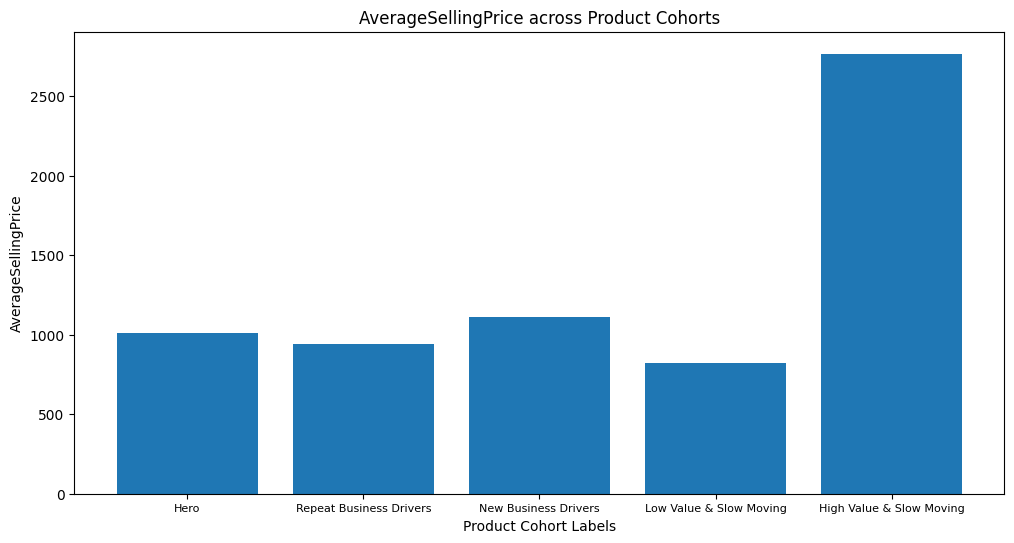

In [25]:
column_to_plot = 'AverageSellingPrice'
x_labels = SummaryTable['Product Cohort Lables2']
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(x_labels, SummaryTable[column_to_plot])
plt.xlabel('Product Cohort Labels')
plt.ylabel(column_to_plot)
plt.title(f'{column_to_plot} across Product Cohorts')
plt.xticks(fontsize=8)
plt.show()

In [26]:
# #Visualization of cohorts with key parameters as axises
# fig = plt.figure(figsize = (15, 15))
# ax = plt.axes(projection ="3d")
# size=segstats['Users']*.05
# # Creating plot
# ax.scatter3D(segstats['CartPenetration'], segstats['NewUserRatio'],segstats['AverageSellingPrice'], s=size)
# plt.title("Product Cohort Distribution")
# ax.set_xlabel('CartPenetration', fontweight ='bold')
# ax.set_ylabel('NewUserRatio', fontweight ='bold')
# ax.set_zlabel('AverageSellingPrice', fontweight ='bold')
# for i in range(len(segstats)):
#      ax.text(segstats['CartPenetration'][i],
#                segstats['NewUserRatio'][i],
#              segstats['AverageSellingPrice'][i],
#                segstats['Product Cohort Lables'][i],
#                horizontalalignment='left',
#                rotation=25, wrap=True,
#                verticalalignment='center',
#                size='medium', color='black')
